In [17]:
import numpy as np
import tensorflow as tf

from PIL import Image

import sys

sys.path.insert(0, "../scripts/")

import utils
import cv2
import os

In [19]:
DS_PATH = "../datasets/all_ds/SciTSR/"
train_names, test_names = os.listdir(DS_PATH + "train/img"), os.listdir(DS_PATH + "test/img")

In [224]:
"""  
Copyright (c) 2019-present NAVER Corp.
MIT License
"""

# -*- coding: utf-8 -*-
import numpy as np
import cv2
import math

""" auxilary functions """
# unwarp corodinates
def warpCoord(Minv, pt):
    out = np.matmul(Minv, (pt[0], pt[1], 1))
    return np.array([out[0]/out[2], out[1]/out[2]])
""" end of auxilary functions """


def getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text):
    # prepare data
    linkmap = linkmap.copy()
    textmap = textmap.copy()
    img_h, img_w = textmap.shape

    """ labeling method """
    ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
    ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

    text_score_comb = np.clip(text_score + link_score, 0, 1)
    nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

    det = []
    mapper = []
    for k in range(1,nLabels):
        # size filtering
        size = stats[k, cv2.CC_STAT_AREA]
        if size < 10: continue

        # thresholding
        if np.max(textmap[labels==k]) < text_threshold: continue

        # make segmentation map
        segmap = np.zeros(textmap.shape, dtype=np.uint8)
        segmap[labels==k] = 255
        segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area
        x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
        w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
        niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
        sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
        # boundary check
        if sx < 0 : sx = 0
        if sy < 0 : sy = 0
        if ex >= img_w: ex = img_w
        if ey >= img_h: ey = img_h
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
        segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

        # make box
        np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
        rectangle = cv2.minAreaRect(np_contours)
        box = cv2.boxPoints(rectangle)

        # align diamond-shape
        w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
        box_ratio = max(w, h) / (min(w, h) + 1e-5)
        if abs(1 - box_ratio) <= 0.1:
            l, r = min(np_contours[:,0]), max(np_contours[:,0])
            t, b = min(np_contours[:,1]), max(np_contours[:,1])
            box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

        # make clock-wise order
        startidx = box.sum(axis=1).argmin()
        box = np.roll(box, 4-startidx, 0)
        box = np.array(box)

        det.append(box)
        mapper.append(k)

    return det, labels, mapper

def getPoly_core(boxes, labels, mapper, linkmap):
    # configs
    num_cp = 5
    max_len_ratio = 0.7
    expand_ratio = 1.45
    max_r = 2.0
    step_r = 0.2

    polys = []  
    for k, box in enumerate(boxes):
        # size filter for small instance
        w, h = int(np.linalg.norm(box[0] - box[1]) + 1), int(np.linalg.norm(box[1] - box[2]) + 1)
        if w < 10 or h < 10:
            polys.append(None); continue

        # warp image
        tar = np.float32([[0,0],[w,0],[w,h],[0,h]])
        M = cv2.getPerspectiveTransform(box, tar)
        word_label = cv2.warpPerspective(labels, M, (w, h), flags=cv2.INTER_NEAREST)
        try:
            Minv = np.linalg.inv(M)
        except:
            polys.append(None); continue

        # binarization for selected label
        cur_label = mapper[k]
        word_label[word_label != cur_label] = 0
        word_label[word_label > 0] = 1

        """ Polygon generation """
        # find top/bottom contours
        cp = []
        max_len = -1
        for i in range(w):
            region = np.where(word_label[:,i] != 0)[0]
            if len(region) < 2 : continue
            cp.append((i, region[0], region[-1]))
            length = region[-1] - region[0] + 1
            if length > max_len: max_len = length

        # pass if max_len is similar to h
        if h * max_len_ratio < max_len:
            polys.append(None); continue

        # get pivot points with fixed length
        tot_seg = num_cp * 2 + 1
        seg_w = w / tot_seg     # segment width
        pp = [None] * num_cp    # init pivot points
        cp_section = [[0, 0]] * tot_seg
        seg_height = [0] * num_cp
        seg_num = 0
        num_sec = 0
        prev_h = -1
        for i in range(0,len(cp)):
            (x, sy, ey) = cp[i]
            if (seg_num + 1) * seg_w <= x and seg_num <= tot_seg:
                # average previous segment
                if num_sec == 0: break
                cp_section[seg_num] = [cp_section[seg_num][0] / num_sec, cp_section[seg_num][1] / num_sec]
                num_sec = 0

                # reset variables
                seg_num += 1
                prev_h = -1

            # accumulate center points
            cy = (sy + ey) * 0.5
            cur_h = ey - sy + 1
            cp_section[seg_num] = [cp_section[seg_num][0] + x, cp_section[seg_num][1] + cy]
            num_sec += 1

            if seg_num % 2 == 0: continue # No polygon area

            if prev_h < cur_h:
                pp[int((seg_num - 1)/2)] = (x, cy)
                seg_height[int((seg_num - 1)/2)] = cur_h
                prev_h = cur_h

        # processing last segment
        if num_sec != 0:
            cp_section[-1] = [cp_section[-1][0] / num_sec, cp_section[-1][1] / num_sec]

        # pass if num of pivots is not sufficient or segment widh is smaller than character height 
        if None in pp or seg_w < np.max(seg_height) * 0.25:
            polys.append(None); continue

        # calc median maximum of pivot points
        half_char_h = np.median(seg_height) * expand_ratio / 2

        # calc gradiant and apply to make horizontal pivots
        new_pp = []
        for i, (x, cy) in enumerate(pp):
            dx = cp_section[i * 2 + 2][0] - cp_section[i * 2][0]
            dy = cp_section[i * 2 + 2][1] - cp_section[i * 2][1]
            if dx == 0:     # gradient if zero
                new_pp.append([x, cy - half_char_h, x, cy + half_char_h])
                continue
            rad = - math.atan2(dy, dx)
            c, s = half_char_h * math.cos(rad), half_char_h * math.sin(rad)
            new_pp.append([x - s, cy - c, x + s, cy + c])

        # get edge points to cover character heatmaps
        isSppFound, isEppFound = False, False
        grad_s = (pp[1][1] - pp[0][1]) / (pp[1][0] - pp[0][0]) + (pp[2][1] - pp[1][1]) / (pp[2][0] - pp[1][0])
        grad_e = (pp[-2][1] - pp[-1][1]) / (pp[-2][0] - pp[-1][0]) + (pp[-3][1] - pp[-2][1]) / (pp[-3][0] - pp[-2][0])
        for r in np.arange(0.5, max_r, step_r):
            dx = 2 * half_char_h * r
            if not isSppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_s * dx
                p = np.array(new_pp[0]) - np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    spp = p
                    isSppFound = True
            if not isEppFound:
                line_img = np.zeros(word_label.shape, dtype=np.uint8)
                dy = grad_e * dx
                p = np.array(new_pp[-1]) + np.array([dx, dy, dx, dy])
                cv2.line(line_img, (int(p[0]), int(p[1])), (int(p[2]), int(p[3])), 1, thickness=1)
                if np.sum(np.logical_and(word_label, line_img)) == 0 or r + 2 * step_r >= max_r:
                    epp = p
                    isEppFound = True
            if isSppFound and isEppFound:
                break

        # pass if boundary of polygon is not found
        if not (isSppFound and isEppFound):
            polys.append(None); continue

        # make final polygon
        poly = []
        poly.append(warpCoord(Minv, (spp[0], spp[1])))
        for p in new_pp:
            poly.append(warpCoord(Minv, (p[0], p[1])))
        poly.append(warpCoord(Minv, (epp[0], epp[1])))
        poly.append(warpCoord(Minv, (epp[2], epp[3])))
        for p in reversed(new_pp):
            poly.append(warpCoord(Minv, (p[2], p[3])))
        poly.append(warpCoord(Minv, (spp[2], spp[3])))

        # add to final result
        polys.append(np.array(poly))

    return polys

def getDetBoxes(textmap, linkmap, text_threshold, link_threshold, low_text, poly=False):
    boxes, labels, mapper = getDetBoxes_core(textmap, linkmap, text_threshold, link_threshold, low_text)

    if poly:
        polys = getPoly_core(boxes, labels, mapper, linkmap)
    else:
        polys = [None] * len(boxes)

    return boxes, polys

def adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net = 2):
    if len(polys) > 0:
        polys = np.array(polys)
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

def cvt2HeatmapImg(img):
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img

def saveResult(img_file, img, boxes, dirname='./result/', verticals=None, texts=None):
    """ save text detection result one by one
    Args:
        img_file (str): image file name
        img (array): raw image context
        boxes (array): array of result file
            Shape: [num_detections, 4] for BB output / [num_detections, 4] for QUAD output
    Return:
        None
    """
    img = np.array(img)

    # make result file list
    filename, file_ext = os.path.splitext(os.path.basename(img_file))

    # result directory
    res_file = dirname + "res_" + filename + '.txt'
    res_img_file = dirname + "res_" + filename + '.jpg'

    if not os.path.isdir(dirname):
        os.mkdir(dirname)

    with open(res_file, 'w') as f:
        for i, box in enumerate(boxes):
            poly = np.array(box).astype(np.int32).reshape((-1))
            strResult = ','.join([str(p) for p in poly]) + '\r\n'
            f.write(strResult)

            poly = poly.reshape(-1, 2)
            cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=2)
            ptColor = (0, 255, 255)
            if verticals is not None:
                if verticals[i]:
                    ptColor = (255, 0, 0)

            if texts is not None:
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.5
                cv2.putText(img, "{}".format(texts[i]), (poly[0][0]+1, poly[0][1]+1), font, font_scale, (0, 0, 0), thickness=1)
                cv2.putText(img, "{}".format(texts[i]), tuple(poly[0]), font, font_scale, (0, 255, 255), thickness=1)

    # Save result image
    cv2.imwrite(res_img_file, img)

In [202]:
mean = (0.485, 0.456, 0.406)
variance = (0.229, 0.224, 0.225)

In [526]:
def read_inp(name, devide=True):
    orig_img = cv2.imread(DS_PATH + "train/img/" + name)
    # print(orig_img)
    resized_image = cv2.resize(orig_img, (600*2, 800))
    # print(resized_image.shape)
    fill_img = np.moveaxis(resized_image, -1, 0)
    # print(fill_img.shape)
    fill_img = np.array([
                (fill_img[0] - mean[0]*255) / (variance[0]*255),
                (fill_img[1] - mean[1]*255) / (variance[1]*255),
                (fill_img[2] - mean[2]*255) / (variance[2]*255)
            ])

    if devide:
        img_left, img_right = fill_img[:, :, :600], fill_img[:, :, 600:]
        orig_img_left, orig_img_right = resized_image[:, :600, :], resized_image[:, 600:, :]
        return tf.convert_to_tensor(img_left, dtype=tf.float32), orig_img_left, tf.convert_to_tensor(img_right, dtype=tf.float32), orig_img_right
        # print(img_left.shape, img_right.shape)
        # images = []
        # for d in range(devide):
        #     scaled_img = 
        #     images

    return tf.convert_to_tensor(fill_img, dtype=tf.float32), orig_img

In [488]:
# inp_img, orig_img = read_inp(train_names[2], )

In [489]:
img1, im1, img2, im2 = read_inp(train_names[2], True)

(800, 1200, 3)
(3, 800, 1200)


In [494]:
img1.shape, im1.shape

(TensorShape([3, 800, 600]), (800, 600, 3))

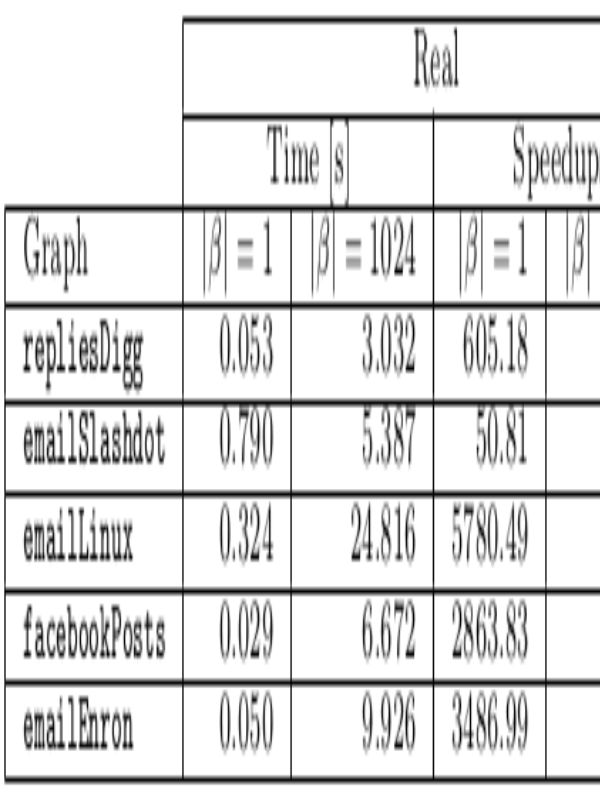

In [493]:
Image.fromarray(im1)

In [435]:
interpreter = tf.lite.Interpreter("../models/lite-model_craft-text-detector_float16_1.tflite")

In [436]:
interpreter.allocate_tensors()

In [410]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [411]:
input_details

[{'name': 'input',
  'index': 0,
  'shape': array([  1,   3, 800, 600], dtype=int32),
  'shape_signature': array([ -1,   3, 800, 600], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [412]:
input_shape = input_details[0]['shape']
interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(inp_img, 0))

In [413]:
interpreter.invoke()

In [414]:
output_data = interpreter.get_tensor(output_details[0]['index'])
# print(output_data)

In [415]:
output_data[0].shape

(400, 300, 2)

In [416]:
score_text = np.array(output_data[0,:,:,0])
score_link = np.array(output_data[0,:,:,1])

In [417]:
# ratio_h = ratio_w = 1 / max(

In [418]:
# Post-processing
boxes, polys = getDetBoxes(score_text, score_link, 0.7, 0.4, 0.4, False)
# print(boxes)
# coordinate adjustments
boxes = adjustResultCoordinates(boxes, 1, 1)
polys = adjustResultCoordinates(polys, 1, 1)
for k in range(len(polys)):
    if polys[k] is None: polys[k] = boxes[k]

In [419]:
render_img = score_text.copy()
render_img = np.hstack((render_img, score_link))

In [420]:
ret_score_text = cvt2HeatmapImg(render_img)

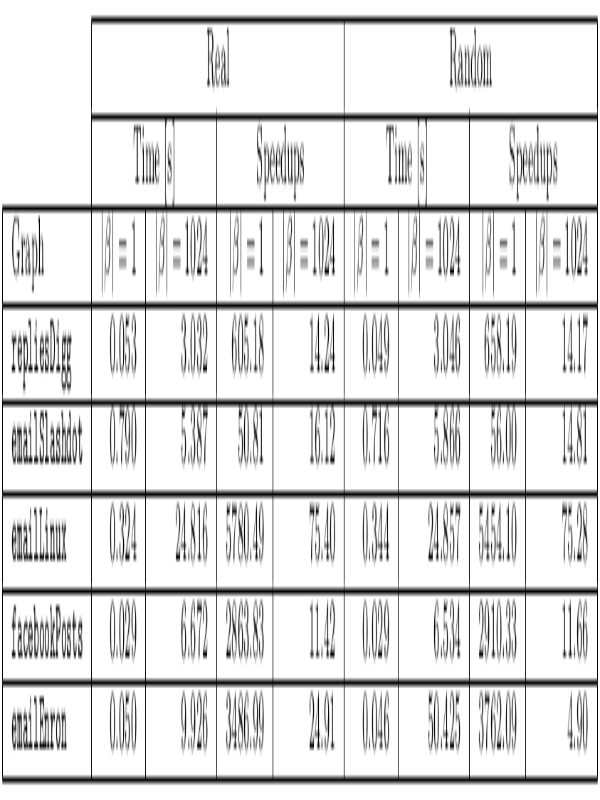

In [421]:
Image.fromarray(orig_img)

In [422]:
img = orig_img.copy()
for i, box in enumerate(polys):
    poly = np.array(box).astype(np.int32).reshape((-1))
    strResult = ', '.join([str(p) for p in poly]) + '\r\n'
    # f.write(strResult)
    # print(strResult)

    poly = poly.reshape(-1, 2)
    # print(poly.reshape((-1, 1, 2)))
    cv2.polylines(img, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=1)
    ptColor = (0, 255, 255)
    # if verticals is not None:
    #     if verticals[i]:
    #         ptColor = (255, 0, 0)

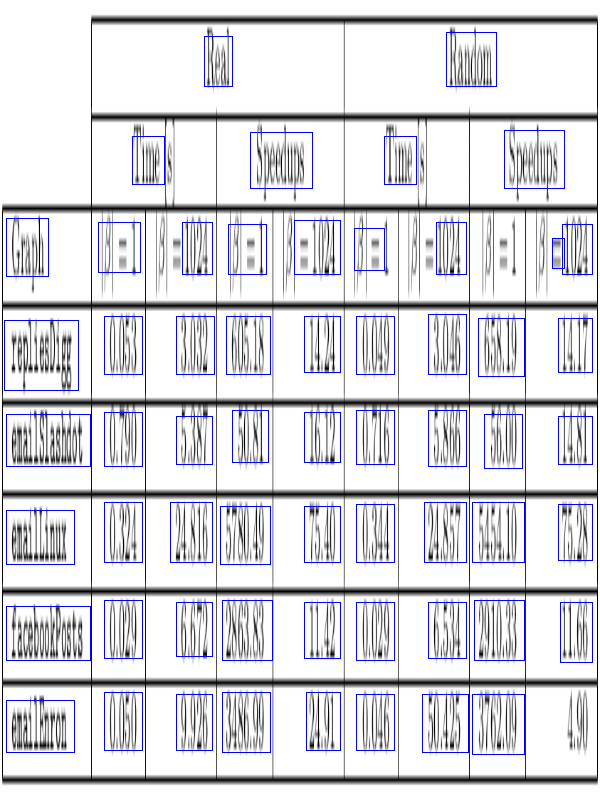

In [423]:
Image.fromarray(img)

In [528]:
def predict(image_name):
    imgl, orl, imgr, orr = read_inp(image_name, devide=True)
    # print(imgl.shape, imgr.shape)
    
    res = []

    for im_inp, im_orig in zip([imgl, imgr], [orl, orr]):
        # print(np.all(im_inp == imgr))
        interpreter.set_tensor(input_details[0]['index'], tf.expand_dims(im_inp, 0))
        interpreter.invoke()

        output_data = interpreter.get_tensor(output_details[0]['index'])
        
        score_text = np.array(output_data[0,:,:,0])
        score_link = np.array(output_data[0,:,:,1])

        # Post-processing
        boxes, polys = getDetBoxes(score_text, score_link, 0.7, 0.4, 0.4, False)
        # print(len(boxes))
        # print(boxes)
        # coordinate adjustments
        boxes = adjustResultCoordinates(boxes, 1, 1)
        polys = adjustResultCoordinates(polys, 1, 1)
        for k in range(len(polys)):
            if polys[k] is None: polys[k] = boxes[k]

        img_out = im_orig.copy()
        for i, box in enumerate(polys):
            poly = np.array(box).astype(np.int32).reshape((-1))
            strResult = ', '.join([str(p) for p in poly]) + '\r\n'

            poly = poly.reshape(-1, 2)
            cv2.polylines(img_out, [poly.reshape((-1, 1, 2))], True, color=(0, 0, 255), thickness=1)
            ptColor = (0, 255, 255)

        res.append(img_out)
    
    return cv2.hconcat([
        res[0], res[1]
    ])

In [551]:
result = predict(train_names[12])

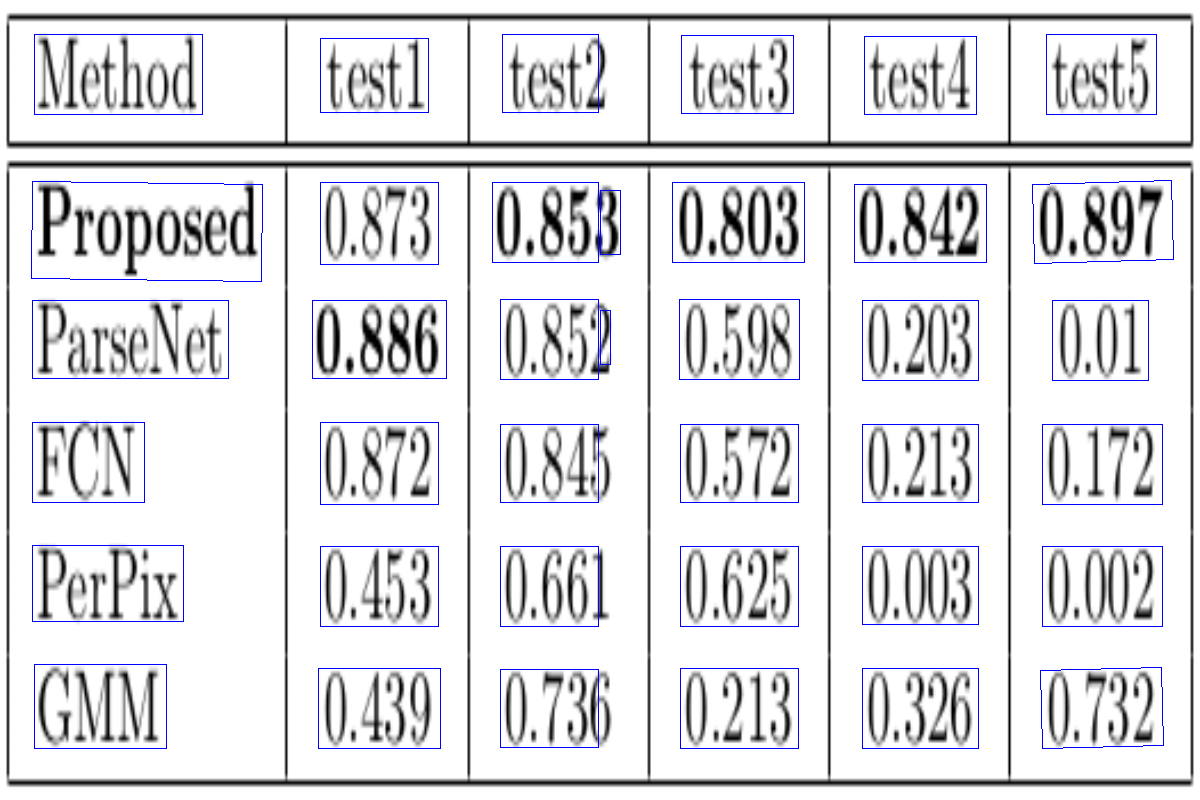

In [552]:
Image.fromarray(result)